In [2]:
!git clone https://github.com/haotian-liu/LLaVA.git
%cd LLaVA
!pip install --upgrade pip  # Upgrade pip to ensure compatibility with latest packages
!pip install .
!pip install langchain langchain_openai
!pip install repl


Cloning into 'LLaVA'...
remote: Enumerating objects: 2297, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 2297 (delta 2), reused 4 (delta 2), pack-reused 2291
Receiving objects: 100% (2297/2297), 13.72 MiB | 36.67 MiB/s, done.
Resolving deltas: 100% (1402/1402), done.
/kaggle/working/LLaVA
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 23.3.2
    Uninstalling pip-23.3.2:
      Successfully uninstalled pip-23.3.2
Processing /kaggle/working/LLaVA
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.7/137.7 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   

2024-07-10 23:58:26.042243: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 23:58:26.042375: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 23:58:26.164991: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_34/2020973255.py:85: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this

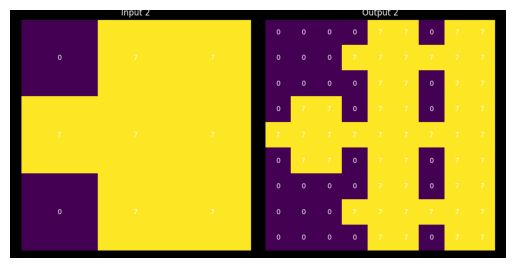

In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path
from llava.eval.run_llava import eval_model

def plot_grid(grid, ax, title="Grid", color_map='viridis'):
    if isinstance(grid, str):
        grid = ast.literal_eval(grid)
    grid = np.array(grid)
    cmap = plt.get_cmap(color_map)
    if grid.size > 0:
        norm = plt.Normalize(np.min(grid), np.max(grid))
        ax.matshow(grid, cmap=cmap, norm=norm)
        for (i, j), val in np.ndenumerate(grid):
            ax.text(j, i, int(val), ha='center', va='center', color='white')
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=12, color='white')
    ax.set_title(title, color='white')
    ax.set_xticks([])
    ax.set_yticks([])

def save_plot(df_row, folder_path, idx):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    plot_grid(df_row.input, axs[0], title=f"Input {idx+1}")
    if df_row.output is not None:
        plot_grid(df_row.output, axs[1], title=f"Output {idx+1}")
    else:
        axs[1].text(0.5, 0.5, 'No output', ha='center', va='center', fontsize=12, color='white')
        axs[1].set_xticks([])
        axs[1].set_yticks([])
    fig.patch.set_facecolor('black')
    plt.tight_layout()

    # Filename based on problem ID and index
    filename = f"{df_row.key}_{idx}.png"
    filepath = os.path.join(folder_path, filename)
    plt.savefig(filepath)
    plt.close(fig)
    return filepath


with open("/kaggle/input/arc-prize-2024/arc-agi_training_challenges.json", 'r') as f:
    data = json.load(f)

# Initialize lists to store flattened data
records = []

# Iterate over each key in JSON data (e.g., "007bbfb7", "00d62c1b")
for key, value in data.items():
    for train_type, train_data in value.items():
        for item in train_data:
            # Flatten the nested structure
            flattened_data = {
                'key': key,
                'train_type': train_type,
                'input': item['input'],
                'output': item.get('output', None)  # 'output' is optional in 'train' data
            }
            records.append(flattened_data)

# Create DataFrame
df = pd.DataFrame(records)
folder_path = '/kaggle/working/train'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Group the DataFrame by problem_id and apply the plotting function
def process_group(group):
    file_paths = []
    for idx, row in enumerate(group.itertuples()):
        file_path = save_plot(row, folder_path, idx)
        file_paths.append(file_path)
    return file_paths

df['file_paths'] = df.groupby('key').apply(process_group).explode().reset_index(drop=True)

# Load the image
image = mpimg.imread(df['file_paths'].iloc[1])

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axes
plt.show()


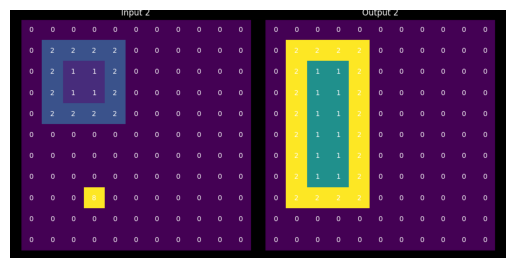

In [27]:
# Load the image
image = mpimg.imread(df['file_paths'].iloc[1200])

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axes
plt.show()


In [3]:
model_path = "liuhaotian/llava-v1.5-7b"

model_path = "liuhaotian/llava-v1.5-7b"
prompt = "What is the puzzle described in the image ?"
image_file = df['file_paths'].iloc[1]

args = type('Args', (), {
    "model_path": model_path,
    "model_base": None,
    "model_name": get_model_name_from_path(model_path),
    "query": prompt,
    "conv_mode": None,
    "image_file": image_file,
    "sep": ",",
    "temperature": 0,
    "top_p": None,
    "num_beams": 1,
    "max_new_tokens": 512
})()

eval_model(args)


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin.index.json:   0%|          | 0.00/27.1k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.54G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `None` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


The puzzle in the image is a two-dimensional puzzle, consisting of a grid of squares, where each square is either yellow or purple. The puzzle is designed to be solved by rearranging the squares to create a specific pattern or configuration.


In [4]:
prompt = """
Given two matrices as in the image, an input matrix and an output matrix, our task is to identify and formalize the transformation rules that convert the input into the output. These matrices are marked by the values '7' and '0', which have specific roles in the transformation. Please analyze the matrices according to the following guidelines and provide detailed insights:

1. Identification of Matrix Structure
    Input Matrix Characteristics:
        What are the dimensions of the input matrix?
        What values are present in the matrix, and how are they arranged?
    Output Matrix Characteristics:
        What are the dimensions of the output matrix?
        How are the values arranged differently from the input matrix?
        
2. Analysis of Transformation Patterns
    Relationship Between Elements:
        How do the positions of '7's in the input relate to their positions in the output?
        Are there any observable patterns in how '7's influence the surrounding space in the output matrix?
    Transformation Types:
        Is the transformation characterized by copying, expanding, or filling of elements?
        How does the transformation affect the distribution and arrangement of '0's?
    Role of Placeholders:
        How are the '0's treated during the transformation? Are they merely placeholders, or do they shift or change in the process?
        
3. Formulation of Transformation Rules
    Direct Mapping:
        Define any direct mappings observed. For example, does a '7' in the input consistently lead to a specific pattern in the output, such as a '+' shape?

    Handling of Inert Elements:
        Determine how non-active elements like '0's are managed within the transformation—are they static, or do they adjust based on the transformation of nearby '7's?

4. Development and Testing of Transformation Code
    Function to Read Input:
        Create a function to process input matrices of varying sizes and compositions. Ensure it can read and interpret the matrix data accurately.
    Transformation Rules Implementation:
        Develop a function that dynamically applies identified transformation rules to the input matrix to generate the output matrix.
    Adaptability and Testing:
        Test the transformation function with different matrix sizes and patterns. Provide a couple of test cases with expected outputs to verify the accuracy and robustness of the transformation rules.
"""

args = type('Args', (), {
    "model_path": model_path,
    "model_base": None,
    "model_name": get_model_name_from_path(model_path),
    "query": prompt,
    "conv_mode": None,
    "image_file": image_file,
    "sep": ",",
    "temperature": 0,
    "top_p": None,
    "num_beams": 1,
    "max_new_tokens": 2048
})()

eval_model(args)


NameError: name 'model_path' is not defined

In [5]:
!pip install langchain langchain_openai


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "image_path": "/kaggle/working/train/007bbfb7_1.png",
  "prompt": "\nPlease provide a detailed description of the matrix structure in the image. Focus on the size (number of rows and columns), the type of elements it contains, and the overall arrangement of these elements. Note any unusual patterns or alignments that might suggest a non-standard matrix structure. For example, are there any nested matrices or blocks within the main matrix? Are the elements numerical, textual, or mixed? This analysis will help in understanding the foundational layout before applying any transformations.\n"
}
[chain/start] [chain:RunnableSequence > chain:TransformChain] Entering Chain run with input:
{
  "image_path": "/kaggle/working/train/007bbfb7_1.png",
  "prompt": "\nPlease provide a detailed description of the matrix structure in the image. Focus on the size (number of rows and columns), the type of elements it contains, and t
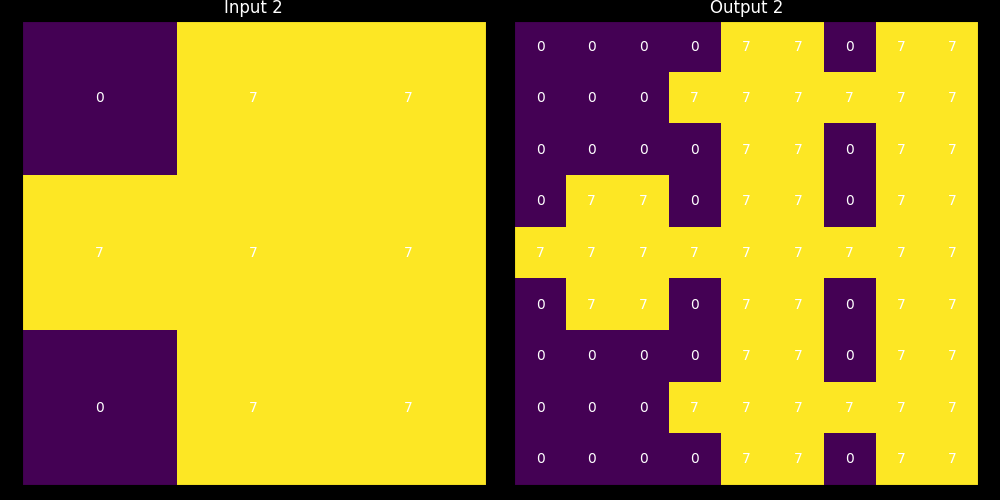
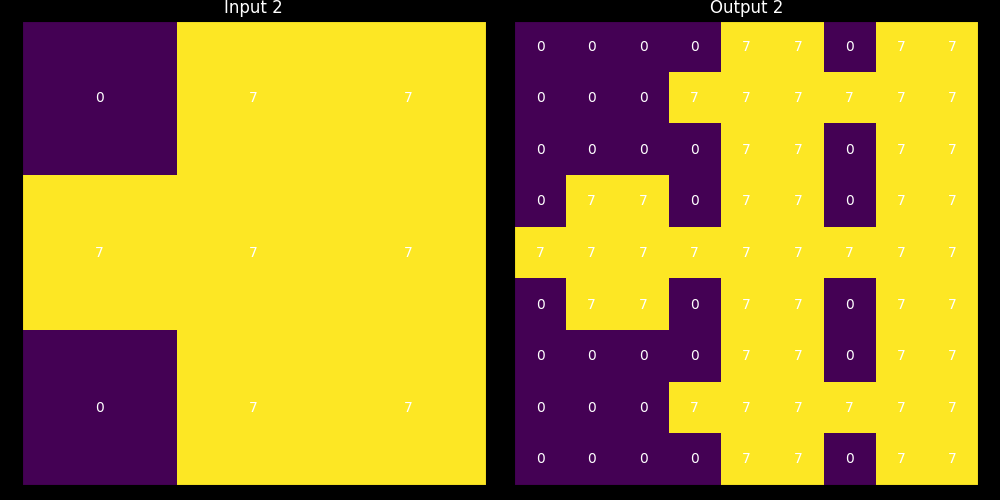
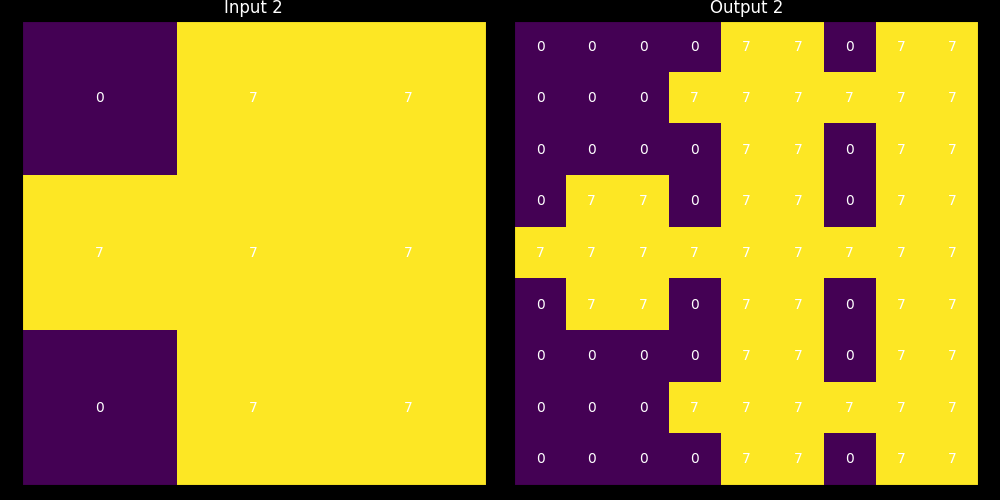
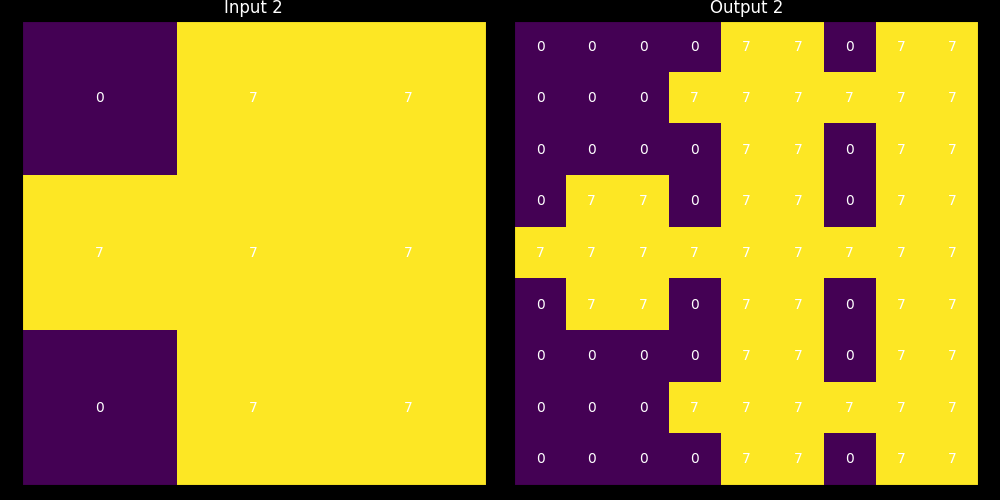

In [26]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.chains import TransformChain
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain import globals
from langchain_core.runnables import chain
from langchain_core.output_parsers import JsonOutputParser
import os
import langchain
import base64

# Setting the OpenAI API Key
os.environ["OPENAI_API_KEY"] = "sk-proj-coC00pN0VTBUhXQSIgwMT3BlbkFJKXzpLehcVAVcxWjiryny"

def encode_image_to_base64(image_path):
    """Load an image file and convert it to a base64 encoded string."""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def load_image(inputs: dict) -> dict:
    """Encode the image at the provided path to base64."""
    image_base64 = encode_image_to_base64(inputs["image_path"])
    return {"image": image_base64}

load_image_chain = TransformChain(
    input_variables=["image_path"],
    output_variables=["image"],
    transform=load_image
)

class ImageTransformationDetails(BaseModel):
    """Model for capturing the transformation rules of matrices in images."""
    structure: str = Field(description="Describe the size and content of the matrices.")
    #pattern_analysis: str = Field(description="Analyze how elements transform from input to output.")
    #rules: str = Field(description="Define rules for transforming matrix elements.")
    #code: str = Field(description="Outline functions for reading and transforming matrices.")

# Enable debugging
globals.set_debug(True)

@chain
def process_image(inputs: dict):
    """Processes an image to model transformation rules."""
    model = ChatOpenAI(temperature=0.5, 
                       model="gpt-4o", 
                       max_tokens=2048)
    msg = model.invoke([HumanMessage(content=[
        {"type": "text", "text": inputs["prompt"]},
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{inputs['image']}"}}
    ])])
    return msg.content

def analyze_image_transformation(image_path: str, prompt: str) -> dict:
    """Analyzes image to identify transformation rules between matrices."""
    #parser = JsonOutputParser(pydantic_object=ImageTransformationDetails)
    vision_chain = load_image_chain | process_image# | parser
    return vision_chain.invoke({'image_path': image_path, 'prompt': prompt})

structure_prompt = """
Please provide a detailed description of the matrix structure in the image. Focus on the size (number of rows and columns), the type of elements it contains, and the overall arrangement of these elements. Note any unusual patterns or alignments that might suggest a non-standard matrix structure. For example, are there any nested matrices or blocks within the main matrix? Are the elements numerical, textual, or mixed? This analysis will help in understanding the foundational layout before applying any transformations.
"""

pattern_prompt = """
Analyze and identify any recurring patterns or sequences in the matrix elements from the image. Describe how these patterns change from one part of the matrix to another, such as gradual increases, periodic repetitions, or symmetrical arrangements. Mention if certain rows or columns follow specific arithmetic or geometric progressions. Understanding these patterns will assist in predicting the matrix transformations or manipulations that might be applicable.
"""

transformation_prompt = """
Formulate comprehensive rules for transforming the matrix based on the observed structures and patterns. Describe step-by-step how to apply these transformations to convert an input matrix into its output form. For instance, if the matrix needs to be rotated, specify the angle and direction; if elements need to be scaled or shifted, provide the scaling factor or shift magnitude. Additionally, propose a generic Python function that can implement these rules dynamically on any given matrix, adjusting to different sizes and patterns.
"""

structure = analyze_image_transformation(df['file_paths'].iloc[1], structure_prompt)
pattern = analyze_image_transformation(df['file_paths'].iloc[1], pattern_prompt)
transformation = analyze_image_transformation(df['file_paths'].iloc[1], transformation_prompt)

code_generation_prompt = f"""
Given the following information about the puzzle in the image, generate code to solve the puzzle in python.
Structural Information: {structure}
Pattern Based Information: {pattern}
Transformation Information: {transformation}

Given the structural, pattern-based, and transformational information, generate a Python script to solve the matrix puzzle depicted in the image. Include functions for:
- Reading and processing input matrices of varying sizes and compositions, ensuring accurate interpretation of data.
- Dynamically applying the identified transformation rules to the input matrix to produce the output matrix.
- Testing the transformation function with different matrix sizes and patterns. Provide test cases with expected outputs to verify the accuracy and robustness of the transformation rules.
Focus on adaptability and error handling to manage different matrix configurations and potential data anomalies effectively.
"""

code = analyze_image_transformation(df['file_paths'].iloc[1], code_generation_prompt)


In [27]:
structure

'The image displays two matrices labeled "Input 2" and "Output 2." Below is a detailed description of each matrix:\n\n### Input 2 Matrix\n\n1. **Size and Dimensions:**\n   - The matrix is a 10x10 grid (10 rows and 10 columns).\n\n2. **Type of Elements:**\n   - The elements are numerical, consisting of two distinct values: 0 and 7.\n\n3. **Arrangement of Elements:**\n   - The matrix has a large block of 7s, with specific areas filled with 0s.\n   - The top-left corner contains a 4x4 block of 0s.\n   - The bottom-left corner contains a 4x4 block of 0s.\n   - The rest of the matrix is filled with 7s.\n\n4. **Patterns and Alignments:**\n   - The 0s form two distinct rectangular blocks within the matrix, located at the top-left and bottom-left corners.\n   - The rest of the matrix is uniformly filled with 7s.\n\n### Output 2 Matrix\n\n1. **Size and Dimensions:**\n   - The matrix is also a 10x10 grid (10 rows and 10 columns).\n\n2. **Type of Elements:**\n   - The elements are numerical, cons

In [28]:
pattern

'### Analysis of the Input Matrix\n\nThe input matrix is a 7x7 grid with two distinct elements: 0 and 7. The matrix is divided into two main regions:\n\n1. **Top-left corner (3x3 block):**\n   - The top-left 3x3 block contains mostly 0s except for the bottom-right cell, which contains a 7.\n   - The elements are arranged as follows:\n     ```\n     0 0 0\n     0 0 0\n     0 0 7\n     ```\n\n2. **Remaining part of the matrix:**\n   - The rest of the matrix (excluding the top-left 3x3 block and the bottom-left 3x3 block) is filled with 7s.\n   - The bottom-left 3x3 block contains mostly 0s except for the top-right cell, which contains a 7.\n   - The elements are arranged as follows:\n     ```\n     7 7 7 7 7 7 7\n     7 7 7 7 7 7 7\n     7 7 7 7 7 7 7\n     7 7 7 7 7 7 7\n     0 0 0 7 7 7 7\n     0 0 0 0 0 0 0\n     0 0 0 0 0 0 0\n     ```\n\n### Analysis of the Output Matrix\n\nThe output matrix is also a 7x7 grid with two distinct elements: 0 and 7. The matrix appears to be a transform

In [29]:
transformation

"To transform the input matrix into the output matrix based on the observed structures and patterns, we need to follow these steps:\n\n1. **Identify the Pattern:**\n   - The transformation involves creating a specific pattern where the values of `7` form a cross or plus sign in each quadrant of the matrix.\n\n2. **Divide the Matrix:**\n   - Divide the input matrix into quadrants.\n\n3. **Create the Cross Pattern in Each Quadrant:**\n   - For each quadrant, create a cross pattern with `7`s. This means setting the center column and center row of each quadrant to `7`.\n\n4. **Handle the Edges:**\n   - Ensure that the edges of the quadrants are handled correctly to avoid overlapping or incorrect placement of `7`s.\n\n### Step-by-Step Transformation:\n\n1. **Divide the Matrix into Quadrants:**\n   - Identify the size of the input matrix (let's assume it's a square matrix of size `n x n`).\n   - Divide the matrix into four quadrants.\n\n2. **Create Cross Pattern in Each Quadrant:**\n   - For

In [30]:
code

'To solve the matrix puzzle depicted in the image, we need to transform the input matrix into the output matrix based on the identified patterns and transformation rules. Here is a step-by-step approach to achieve this using Python:\n\n### Step-by-Step Approach:\n\n1. **Read and Process Input Matrix:**\n   - Read the input matrix from a given source (e.g., file, direct input, etc.).\n   - Ensure the matrix is correctly interpreted as a 2D array.\n\n2. **Apply Transformation Rules:**\n   - Identify the quadrants of the matrix.\n   - Apply the cross pattern of `7`s to each quadrant.\n\n3. **Test the Transformation Function:**\n   - Verify the function with different matrix sizes and patterns.\n   - Include error handling for potential data anomalies.\n\nHere\'s the Python script that implements the above approach:\n\n```python\nimport numpy as np\n\ndef create_cross_pattern(matrix, top_left_row, top_left_col, size):\n    center_row = top_left_row + size // 2\n    center_col = top_left_co

In [31]:
ip_op_matrix = exec(code.split("```python")[1].split("\n```")[0])
ip_op_matrix

Input Matrix:
0 0 0 0 7 7 7 7 7 7
0 0 0 0 7 7 7 7 7 7
0 0 0 0 7 7 7 7 7 7
0 0 0 0 7 7 7 7 7 7
7 7 7 7 7 7 7 7 7 7
7 7 7 7 7 7 7 7 7 7
0 0 0 0 7 7 7 7 7 7
0 0 0 0 7 7 7 7 7 7
0 0 0 0 7 7 7 7 7 7
0 0 0 0 7 7 7 7 7 7

Output Matrix:
0 0 7 0 0 0 0 7 0 0
0 0 7 0 0 0 0 7 0 0
7 7 7 7 7 7 7 7 7 7
0 0 7 0 0 0 0 7 0 0
0 0 7 0 0 0 0 7 0 0
0 0 7 0 0 0 0 7 0 0
0 0 7 0 0 0 0 7 0 0
7 7 7 7 7 7 7 7 7 7
0 0 7 0 0 0 0 7 0 0
0 0 7 0 0 0 0 7 0 0


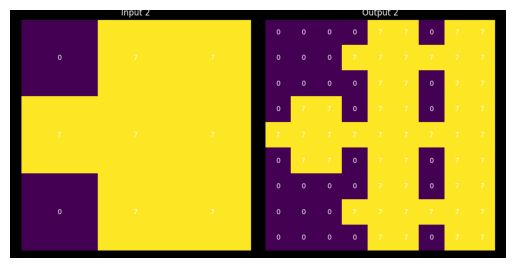

In [19]:
# Load the image
image = mpimg.imread(df['file_paths'].iloc[1])

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axes
plt.show()


[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "image_path": "/kaggle/working/train/007bbfb7_1.png",
  "prompt": "\nPlease provide a detailed description of the matrix structure in the image. Focus on the size (number of rows and columns), the type of elements it contains, and the overall arrangement of these elements. Note any unusual patterns or alignments that might suggest a non-standard matrix structure. For example, are there any nested matrices or blocks within the main matrix? Are the elements numerical, textual, or mixed? This analysis will help in understanding the foundational layout before applying any transformations.\n"
}
[chain/start] [chain:RunnableSequence > chain:TransformChain] Entering Chain run with input:
{
  "image_path": "/kaggle/working/train/007bbfb7_1.png",
  "prompt": "\nPlease provide a detailed description of the matrix structure in the image. Focus on the size (number of rows and columns), the type of elements it contains, and t
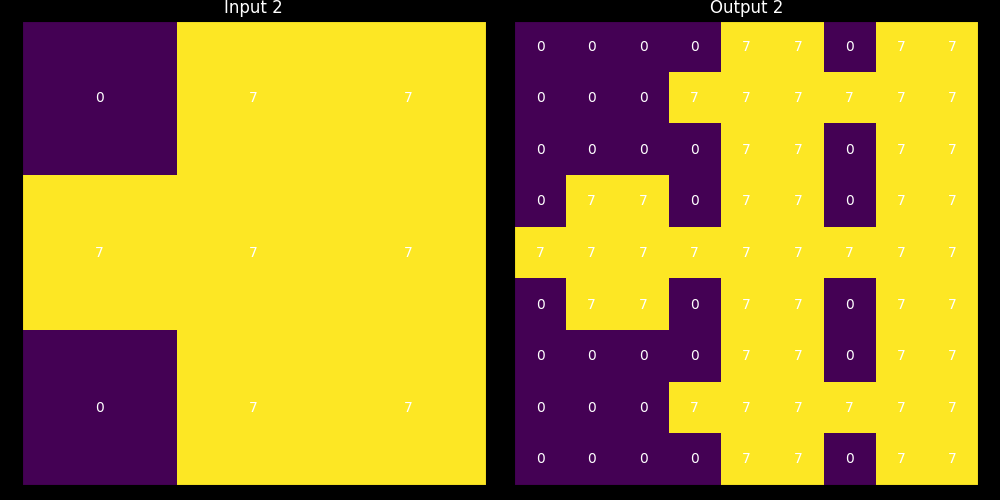

'The image contains two matrices labeled "Input 2" and "Output 2". Below is a detailed description of each:\n\n### Input 2 Matrix\n- **Size**: 8 rows x 8 columns.\n- **Elements**: Numerical, specifically the numbers 0 and 7.\n- **Arrangement**:\n  - The matrix is divided into distinct blocks:\n    - The top left quadrant (4x4) is mostly filled with 0s, with the exception of some 7s in the lower part of this quadrant.\n    - The bottom left quadrant (4x4) is similar, with a block of 0s and a few 7s.\n    - The right half (4x8) is entirely filled with the number 7.\n  - This creates a pattern where the left side has two blocks of 0s in the top and bottom quadrants, and the right side is uniformly filled with 7s.\n\n### Output 2 Matrix\n- **Size**: 8 rows x 8 columns.\n- **Elements**: Numerical, specifically the numbers 0 and 7.\n- **Arrangement**:\n  - The matrix is more complex in its structure compared to the Input matrix.\n  - The 0s and 7s form a pattern that resembles a maze or a gr

In [61]:
validation_prompt = f"""
Given the image of an input matrix and a transformed output matrix, is the input output matrix in text format below same as the screenshot ?
{ip_op_matrix}..
Respond with yes or no and a short reasoning
"""

validation = analyze_image_transformation(df['file_paths'].iloc[1], structure_prompt)
validation